## 1. Import Required Packages

In [38]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import functional as T

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


from tqdm.auto import tqdm

In [4]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='mps')

## 2. Dataset Preparation and Visualization

In [5]:
default_test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=None
)

Files already downloaded and verified


### Definition of Fix-Scale Transform and Multi-Scale Transform

In [6]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

def fix_scale_transform(s, random_crop=True):
  return transforms.Compose([
    transforms.Resize(s),
    transforms.RandomCrop(32) if random_crop else transforms.Lambda(lambda x: x),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.2,
      hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ])

def multi_scale_transform(s_min, s_max):
  area = 32**2
  min_area = s_min**2
  max_area = s_max**2
  
  return transforms.Compose([
    transforms.RandomResizedCrop(
      size=32,
      scale=(area / max_area, area / min_area),
      ratio=(1.0, 1.0)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.2,
      hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ])

In [7]:
def denormalize(img: torch.Tensor):
  return torch.clamp(img * std[:, None, None] + mean[:, None, None], min=0)

### Fix-Scale Transform Visualization

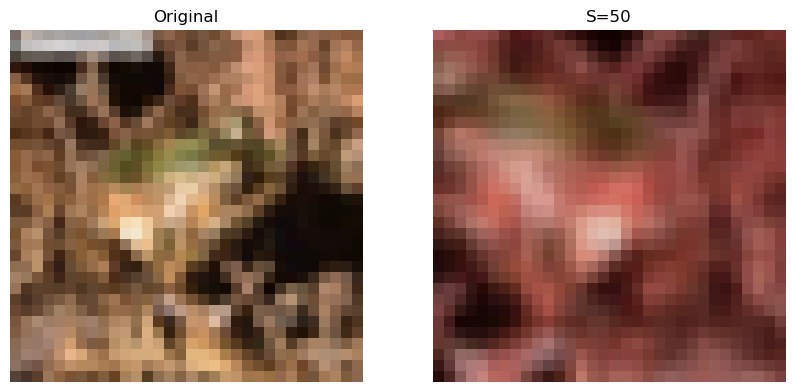

In [8]:
s = 50

img, label = default_test_dataset[np.random.choice(len(default_test_dataset))]
img_fst_50 = fix_scale_transform(s)(img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("S=50")
plt.imshow(denormalize(img_fst_50).permute(1, 2, 0))
plt.axis(False)

plt.show()

### Multi-Scale Transform Visualization

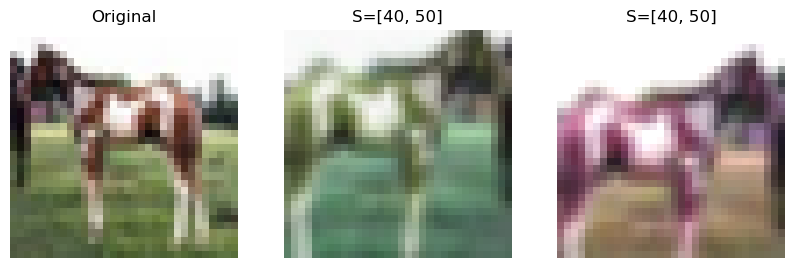

In [9]:
s_min, s_max = 40, 50

mst_40_50 = multi_scale_transform(s_min, s_max)

img, label = default_test_dataset[np.random.choice(len(default_test_dataset))]
img_mst_40_50_1 = mst_40_50(img)
img_mst_40_50_2 = mst_40_50(img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 3, 2)
plt.title("S=[40, 50]")
plt.imshow(denormalize(img_mst_40_50_1).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 3, 3)
plt.title("S=[40, 50]")
plt.imshow(denormalize(img_mst_40_50_2).permute(1, 2, 0))
plt.axis(False)

plt.show()

### Definition of PairedFlipDataset and MultiTransformDataset

In [10]:
class PairedFlipDataset(Dataset):
  """
  Wraps a base dataset that already includes transforms, and returns
  both the original image and its horizontally flipped version, along with the label.

  Assumes:
      - The base dataset returns (transformed_image, label) pairs.
      - The image is already preprocessed (e.g., resized, normalized).

  Returns:
      (original_image, flipped_image, label)
  """
  
  def __init__(self, base_dataset):
    self.base_dataset = base_dataset
    
  def __len__(self):
    return len(self.base_dataset)
  
  def __getitem__(self, idx):
    img, label = self.base_dataset[idx]
    
    img_flipped = T.hflip(img)
    
    return img, img_flipped, label

class MultiTransformDataset(Dataset):
  """
  Applies multiple transforms to the same input image from the base dataset,
  and returns all transformed versions along with the label.

  Assumes:
      - The base dataset returns (PIL image, label) pairs, with no transform applied.
      - A list of transform functions (e.g., torchvision.transforms.Compose) is provided.

  Args:
      base_dataset: A dataset yielding untransformed (PIL image, label) pairs.
      *trans: One or more transform functions to apply to the input image.

  Returns:
      (*transformed_images, label)
  """
  
  def __init__(self, base_dataset, *trans):
    self.base_dataset = base_dataset
    self.trans = trans
    
  def __len__(self):
    return len(self.base_dataset)
  
  def __getitem__(self, idx):
    img, label = self.base_dataset[idx]
    
    imgs = [tran(img) for tran in self.trans]
    
    return *imgs, label

### PairedFlipDataset Visualization

Files already downloaded and verified


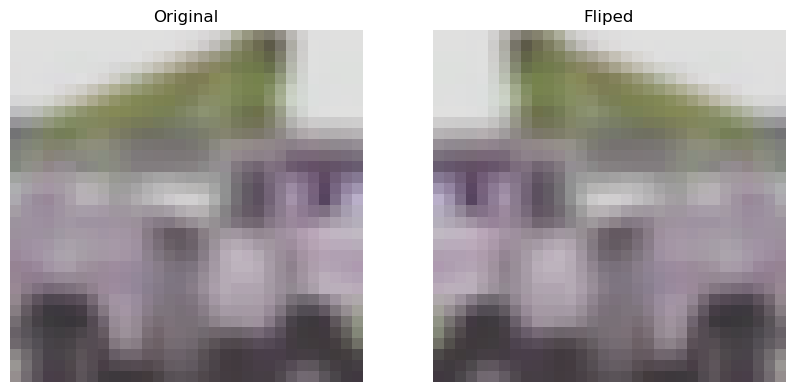

In [11]:
fst_50 = fix_scale_transform(50)

fst_50_test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=fst_50
)

fst_50_paired_flip_test_dataset = PairedFlipDataset(fst_50_test_dataset)

img, img_flipped, label = fst_50_paired_flip_test_dataset[np.random.choice(len(fst_50_paired_flip_test_dataset))]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(denormalize(img).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("Fliped")
plt.imshow(denormalize(img_flipped).permute(1, 2, 0))
plt.axis(False)

plt.show()

### MultiTransformDataset Visualization

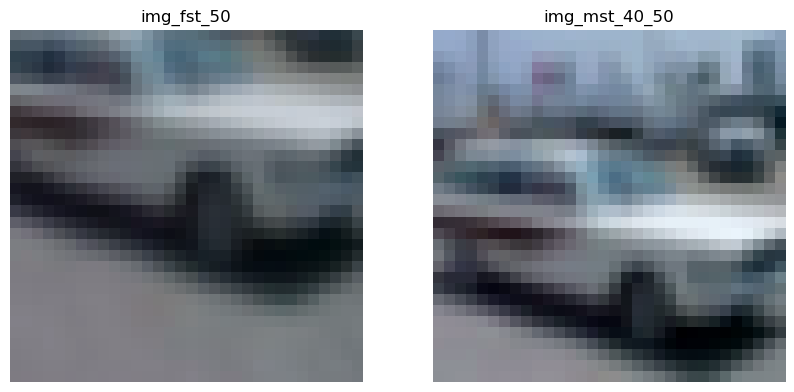

In [12]:
fst_50 = fix_scale_transform(50)
mst_40_50 = multi_scale_transform(40, 50)

multi_trans_test_dataset = MultiTransformDataset(default_test_dataset, fst_50, mst_40_50)

img_fst_50, img_mst_40_50, label = multi_trans_test_dataset[np.random.choice(len(fst_50_paired_flip_test_dataset))]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("img_fst_50")
plt.imshow(denormalize(img_fst_50).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("img_mst_40_50")
plt.imshow(denormalize(img_mst_40_50).permute(1, 2, 0))
plt.axis(False)

plt.show()

## 3. Training and Evaluation Functions

In [ ]:
class Trainer:
  def __init__(self, model_class, train_transform, test_transform):
    self.model_class = model_class
    self.train_transform = train_transform
    self.test_transform = test_transform
    
    self.epoch = 0
    self.logs = [[], [], [], []]
    
    self.train_dataset = datasets.CIFAR10(
      root="data",
      download=True,
      train=True,
      transform=self.train_transform
    )
    
    self.test_dataset = PairedFlipDataset(datasets.CIFAR10(
      root="data",
      download=True,
      train=False,
      transform=self.test_transform
    ))
    
    self.batch_size = 32

    self.train_dataloader = DataLoader(
      dataset=self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      pin_memory=True
    )

    self.test_dataloader = DataLoader(
      dataset=self.test_dataset,
      batch_size=self.batch_size,
      shuffle=False,
      pin_memory=True
    )

    self.model = self.model_class().to(device)

    self.criterion = nn.CrossEntropyLoss()

    self.optimizer = torch.optim.SGD(
      params=self.model.parameters(),
      momentum=0.9,
      lr=0.01
    )
    
    self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
		  self.optimizer,
      "max",
      factor=0.1,
      patience=3
		)

    self.accuracy = Accuracy(
      task="multiclass",
      num_classes=len(self.train_dataset.classes)
    ).to(device)
    
  def train(self, epoch=1):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for cur_epoch in range(self.epoch + 1, self.epoch + epoch + 1):
      train_loss, train_acc = self._train_epoch()
      val_loss, val_acc = self._validate_epoch()

      self.scheduler.step(val_acc)

      train_losses.append(train_loss)
      train_accs.append(train_acc)
      val_losses.append(val_loss)
      val_accs.append(val_acc)

      self.epoch = cur_epoch

      print(f"Epoch: {cur_epoch: 4d} | Train loss: {train_loss: .5f} | Train acc: {train_acc: .5f} | Val loss: {val_loss: .5f} | Val acc: {val_acc: .5f}")

    self._concat_logs(train_losses, train_accs, val_losses, val_accs)
    self._plot_train_log()
  
  def validate(self):
    self.model.eval()

    val_acc = 0

    with torch.no_grad():
      for X1, X2, y in tqdm(self.test_dataloader, desc="Validate", leave=False):
        X1, X2, y = self._to_device(X1, X2, y)

        logits1 = self.model(X1)
        probs1 = torch.softmax(logits1, dim=1)

        logits2 = self.model(X2)
        probs2 = torch.softmax(logits2, dim=1)

        probs = (probs1 + probs2) / 2
        preds = probs.argmax(dim=1)

        val_acc += self.accuracy(preds, y).cpu().item()

    val_acc /= len(self.test_dataloader)

    return val_acc
  
  def _train_epoch(self):
    self.model.train()

    train_loss, train_acc = 0, 0

    for X, y in tqdm(self.train_dataloader, desc="Training", leave=False):
      X, y = self._to_device(X, y)

      logits = self.model(X)

      loss = self.criterion(logits, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      with torch.no_grad():
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        train_loss += loss.cpu().item()
        train_acc += self.accuracy(preds, y).cpu().item()

    train_loss /= len(self.train_dataloader)
    train_acc /= len(self.train_dataloader)

    return train_loss, train_acc
  
  def _validate_epoch(self):
    self.model.eval()

    val_loss, val_acc = 0, 0

    with torch.no_grad():
      for X, _, y in tqdm(self.test_dataloader, desc="Validate", leave=False):
        X, y = self._to_device(X, y)

        logits = self.model(X)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        loss = self.criterion(logits, y)

        val_loss += loss.cpu().item()
        val_acc += self.accuracy(preds, y).cpu().item()

    val_loss /= len(self.test_dataloader)
    val_acc /= len(self.test_dataloader)

    return val_loss, val_acc
  
  def _plot_train_log(self):
    train_losses, train_accs, val_losses, val_accs = self.logs
    
    epochs = np.arange(1, self.epoch + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", linewidth=2, marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2, marker='s')
    plt.title("Loss over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy", linewidth=2, marker='o')
    plt.plot(epochs, val_accs, label="Validation Accuracy", linewidth=2, marker='s')
    plt.title("Accuracy over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()
  
  def _concat_logs(self, *logs):
    self.logs = [[*log1, *log2] for log1, log2 in zip(self.logs, logs)]
  
  def _to_device(self, *args, device=device):
    return [arg.to(device, non_blocking=True) for arg in args]

Files already downloaded and verified
Files already downloaded and verified


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  1.92515 | Train acc:  0.25412 | Val loss:  1.83751 | Val acc:  0.30471


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  1.70672 | Train acc:  0.36178 | Val loss:  1.78448 | Val acc:  0.33437


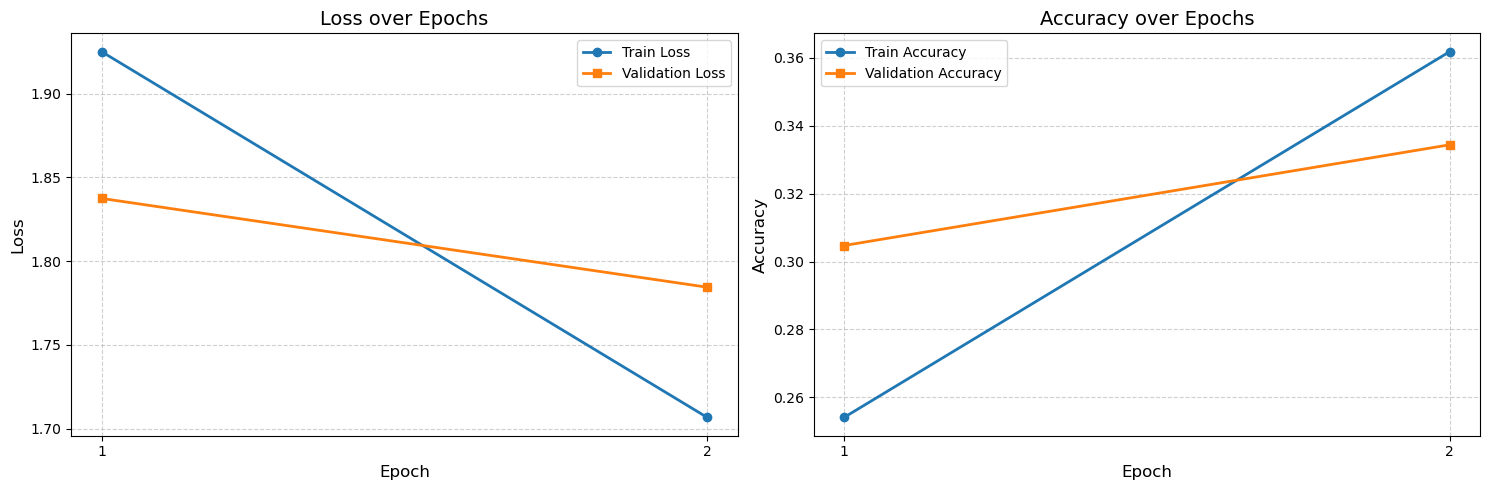

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  1.58962 | Train acc:  0.42556 | Val loss:  1.61542 | Val acc:  0.42951


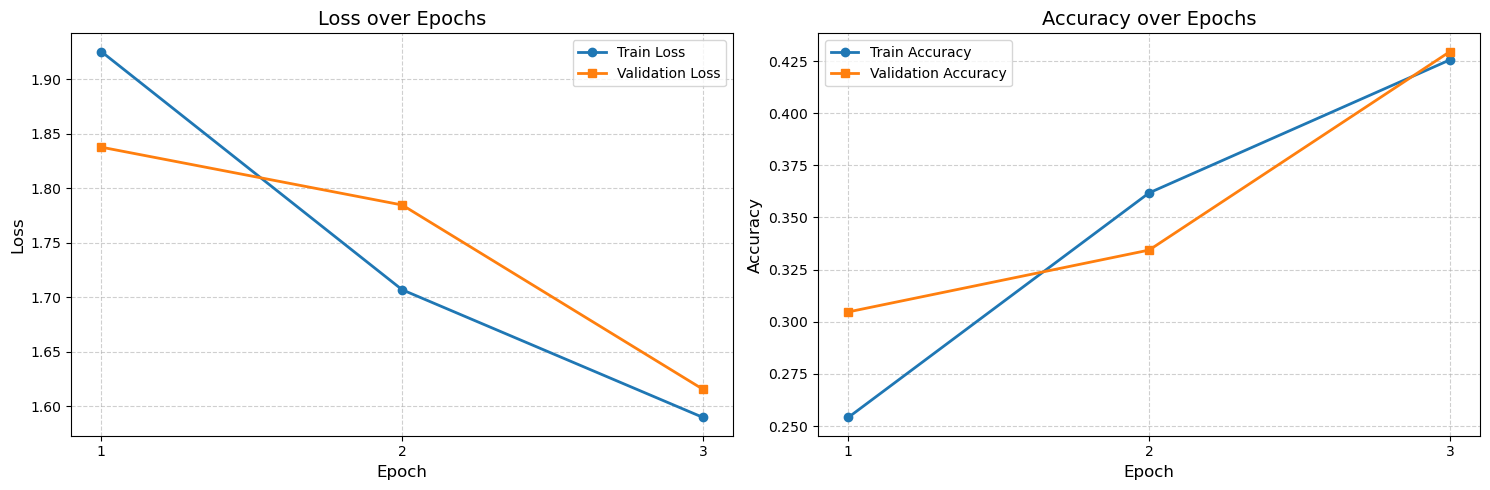

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

0.44369009584664537

In [40]:
trainer = Trainer(
  TinyVGG_A,
  fix_scale_transform(s=40),
  fix_scale_transform(s=50)
)

trainer.train(2) # first epochs of train
trainer.train(1) # ... additional epochs of train

trainer.validate()

## 4. Model Architecture

In [15]:
class VGGBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_convs, kernel_sizes=3):
    super().__init__()
    
    assert isinstance(kernel_sizes, int) or len(kernel_sizes) == n_convs
    
    if isinstance(kernel_sizes, int):
      kernel_sizes = [kernel_sizes for _ in range(n_convs)]
        
    paddings = [(kernel_size - 1) // 2 for kernel_size in kernel_sizes]
    
    layers = []

    for kernel_size, padding in zip(kernel_sizes, paddings):
      assert 2 * padding - kernel_size + 1 == 0

      layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.ReLU(inplace=True))

      in_channels = out_channels

    layers.append(nn.MaxPool2d(kernel_size=2))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

### TinyVGG A

In [16]:
class TinyVGG_A(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=1),
      VGGBlock(8, 16, n_convs=1),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

### TinyVGG B

In [ ]:
class TinyVGG_B(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

### TinyVGG C

In [ ]:
class TinyVGG_C(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=3, kernel_sizes=(3, 3, 1)),
      VGGBlock(32, 64, n_convs=3, kernel_sizes=(3, 3, 1)),
      VGGBlock(64, 64, n_convs=3, kernel_sizes=(3, 3, 1)),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

### TinyVGG D

In [ ]:
class TinyVGG_D(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=3),
      VGGBlock(32, 64, n_convs=3),
      VGGBlock(64, 64, n_convs=3),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

### TinyVGG E

In [ ]:
class TinyVGG_E(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=4),
      VGGBlock(32, 64, n_convs=4),
      VGGBlock(64, 64, n_convs=4),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

## 5. Training